## Importing Libraries

In [70]:
import pandas as pd
import json
import os
import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [54]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/riccardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/riccardo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/riccardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading and Pre-Processing

In [22]:
pd.set_option("max_colwidth", None)
plt.style.use("ggplot")

Loading environmental variable in order to not show the path to the file

In [3]:
load_dotenv()
path = os.getenv('FILE_PATH')

This function is useful in order to load the json file, create a dataframe starting from a list of dictionaries containing titles, bodies and ratings.

In [4]:
def creating_ds():
    with open(str(path), 'r') as json_file:
        data = json.load(json_file)
    
    reviews = {"Title": [], "Content": [], "Stars": [], "Verified": [], "Date": []}

    for page in data:
        if len(page) != 0: # if there are reviews in that page list
            for i in range(len(page['Body'])):
                reviews['Title'].append(page['Title'][i].strip().lower())
                reviews['Content'].append(page['Body'][i].strip().lower())
                reviews['Stars'].append(page['Stars'][i][:1])
                reviews['Verified'].append(page['Verified'][i].strip().lower())
                reviews['Date'].append(page['Date'][i].strip())
    
    reviews = pd.DataFrame.from_dict(reviews)
    return reviews

In [5]:
df = creating_ds()
df.head()

,Title,Content,Stars,Verified,Date
0,"very comfortable, responsive, very quiet (tho not completely silent)","i've been having trouble with my bluetooth mouse lately. it takes a while to connect, and drops connection every time my laptop goes to sleep.\n\ni figured it's time to revert back to a usb mouse that, even though it does take up a usb port, at least is consistently reliable.\n\nthis one does not fail. responsiveness is perfect, and the left and right buttons don't take much to activate.\n\ni especially love the flattened shape of the mouse. the footprint of it is the size of a standard, full sized mouse, but the overall shape is flatter. this means that my hand and fingers curve over it flatter rather than curled. to me, it just feels more natural and comfortable.\n\ni am a 5'4"" woman, but my 6'2"" husband has tried it too. he said it initially felt a bit odd. he said it felt like his entire hand covered it, but after using it for several days, he asked me to order one for him too.\n\nif you're gaming, heavy into graphic arts or needing a mouse with a lot of options, this may not be for you. but, for ordinary office and personal use, we are very happy with this.\n\nthe price is fantastic and the fact that it even comes with a battery is unheard of.",5,verified purchase,"Reviewed in the United States on September 28, 2023"
1,it's a simple mouse. it works well!,nothing to complain. mouse works.,5,verified purchase,"Reviewed in the United States on December 8, 2023"
2,"lenovo 530. wireless computer mouse for pc, laptop. large and comfortable. no sticky plastic.","the ""lenovo 530 wireless mouse"" is a good option for a wireless mouse that is both affordable and reliable.\n\nit has a 2.4 ghz wireless connection that is strong and consistent, and it also has a long battery life of up to 12 months. the mouse is ambidextrous, so it can be used by both left-handed and right-handed users.\n\nit's full sized and is a basic three-button mouse with a wheel.\n\nno extra side buttons to get in the way or sticky soft plastic that is hard to keep clean.\n\npros:\n\naffordable\nlong battery life\nambidextrous design\n2.4 ghz wireless connection\nsimple and basic with no extra buttons or unusual shape\ncomfortable to use for those with larger hands.\n\ncons:\n\nthe scroll wheel can be a bit stiff.\nmay be too large for smaller hands\ntakes up more space for travel or portable users\nsmall usb dongle is needed to use and can be lost, misplaced, or forgotten.\n\noverall, the lenovo 530 wireless mouse is a good option for a wireless mouse that is both affordable and reliable. it is a good choice for both home and office use.",5,verified purchase,"Reviewed in the United States on August 17, 2023"
3,not as good as past mouse... but ok.,"got this because i usually love lenovo keyboards and their mouse. but this one was a little ""fat"" and not great with batteries. but still pretty good. will look for a different kind when this one dies.",5,verified purchase,"Reviewed in the United States on October 31, 2023"
4,great product,like everything about it.,4,verified purchase,"Reviewed in the United States on November 16, 2023"


In [6]:
df.isna().sum() # checking for null values

Title       0
Content     0
Stars       0
Verified    0
Date        0
dtype: int64

### Text adjustments

In [7]:
# Removing special characters
def clean(content):
    content = re.sub('\W+',' ', content )                             # special characters
    content = re.sub(r'[:;=]\s*[-]?[)D(\[\]/\\OpP]', '', content)     # emoticons
    content = re.sub(r'[^\w\s]', '', content)                         # punctuation
    return content

def remove_url(content): # removing urls
    return re.sub(r'http\S+', '', content)

# Data preprocessing
def data_cleaning(content):
    content = remove_url(content)
    content = clean(content)   
    return content

In [8]:
def parse_date(date):
    words = date.split()

    # Find the index of the word "on"
    try:
        index_of_on = words.index('on')
    except ValueError:
        # If 'on' is not found, return the original string
        return date

    # Extract the date information starting from the word after "on"
    date_string = ' '.join(words[index_of_on + 1:])
    date_obj = datetime.datetime.strptime(date_string, '%B %d, %Y')
    formatted_date = date_obj.strftime('%Y-%m-%d')
    return formatted_date

In [9]:
def divide_date(date):
    year, month, day = map(int, date.split('-'))
    return year, month, day

In [10]:
df['Clean Review'] = df['Title'] + ' ' + df['Content']
df['Clean Review'] = df['Clean Review'].apply(data_cleaning)

In [11]:
df['Date'] = df['Date'].apply(parse_date)

In [12]:
df['Year'], df['Month'], df['Day'] = zip(*df['Date'].apply(divide_date))

Here I calculate the sentiment only based on the star the use gave to the product

In [13]:
def calculate_sentiment_from_stars(stars):
    if stars == '5' or stars == '4':
        sentiment = 'Positive'
    elif stars == '3':
        sentiment = 'Neutral'
    elif stars == '2' or stars == '1':
        sentiment = 'Negative'
    return sentiment

In [14]:
df['Sentiment from Stars'] = df['Stars'].apply(calculate_sentiment_from_stars)

In [50]:
def remove_stopwords(content):
    words = nltk.word_tokenize(content)
    return ' '.join([word for word in words if word not in stopwords.words('english')])

In [55]:
def lemmatize(content):
    words = word_tokenize(content)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, wordnet.VERB) for word in words])

In [56]:
df['Clean Review'] = df['Clean Review'].apply(remove_stopwords)
df['Clean Review'] = df['Clean Review'].apply(lemmatize)

## EDA and Plots

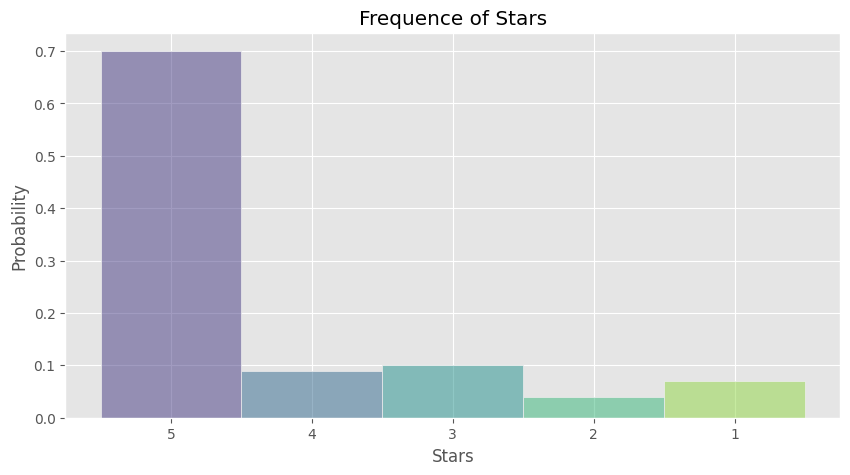

In [57]:
plt.figure(figsize=(10, 5))
sns.histplot(x=df['Stars'], bins=len(df['Stars'].unique()), kde=False, palette='viridis', hue=df['Stars'], stat='probability', legend=False)

# Add labels and title
plt.xlabel('Stars')
plt.title('Frequence of Stars')

# Show the plot
plt.show()

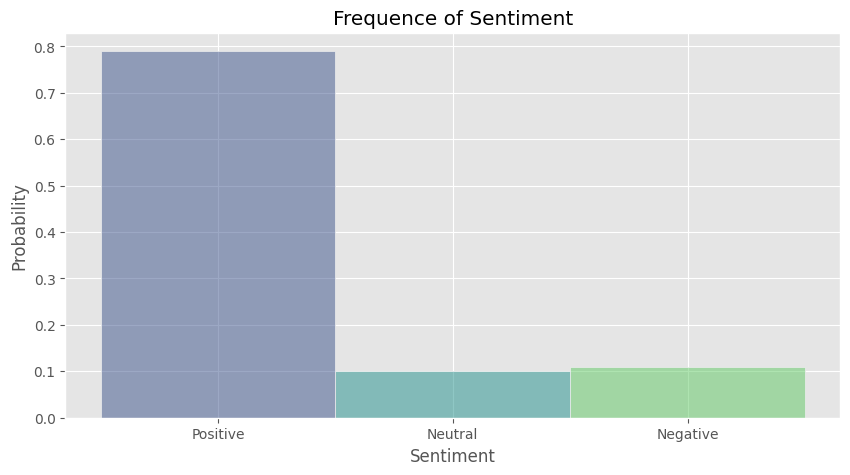

In [58]:
plt.figure(figsize=(10, 5))
sns.histplot(x=df['Sentiment from Stars'], bins=len(df['Sentiment from Stars'].unique()), kde=False, palette='viridis', hue=df['Sentiment from Stars'], stat='probability', legend=False)

# Add labels and title
plt.xlabel('Sentiment')
plt.title('Frequence of Sentiment')

# Show the plot
plt.show()

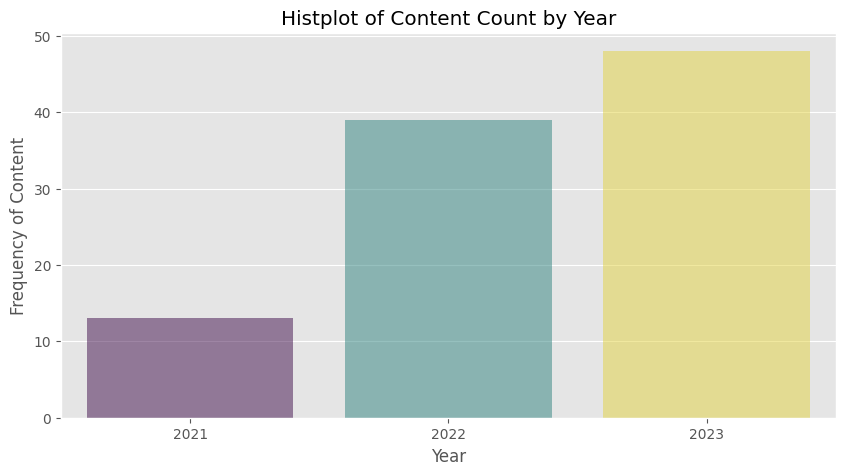

In [59]:
year_group = pd.DataFrame(df.groupby('Year')['Content'].count().reset_index(name='Count'))
plt.figure(figsize=(10, 5))
sns.barplot(data=year_group, x='Year', y='Count', palette='viridis', legend=False, hue='Year', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency of Content')
plt.title('Histplot of Content Count by Year')

# Show the plot
plt.show()

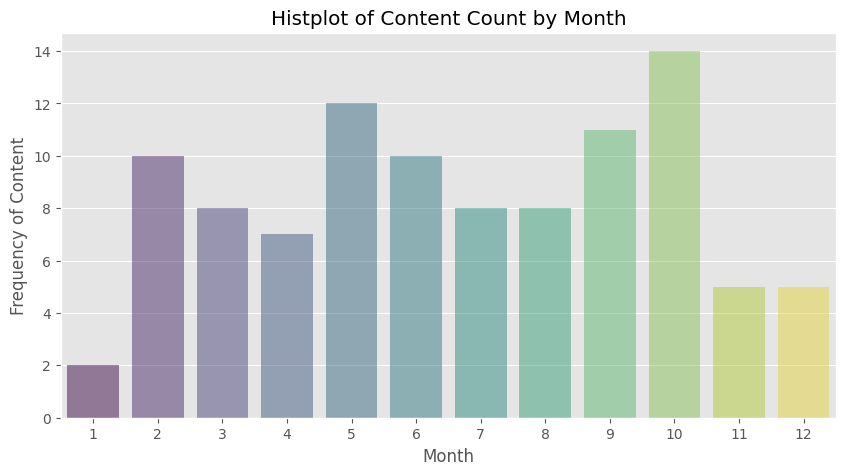

In [60]:
month_group = pd.DataFrame(df.groupby('Month')['Content'].count().reset_index(name='Count'))
plt.figure(figsize=(10, 5))
sns.barplot(data=month_group, x='Month', y='Count', palette='viridis', legend=False, hue='Month', alpha=0.5)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Frequency of Content')
plt.title('Histplot of Content Count by Month')

# Show the plot
plt.show()

In [27]:
def count_words(content):
    return len(content.split())

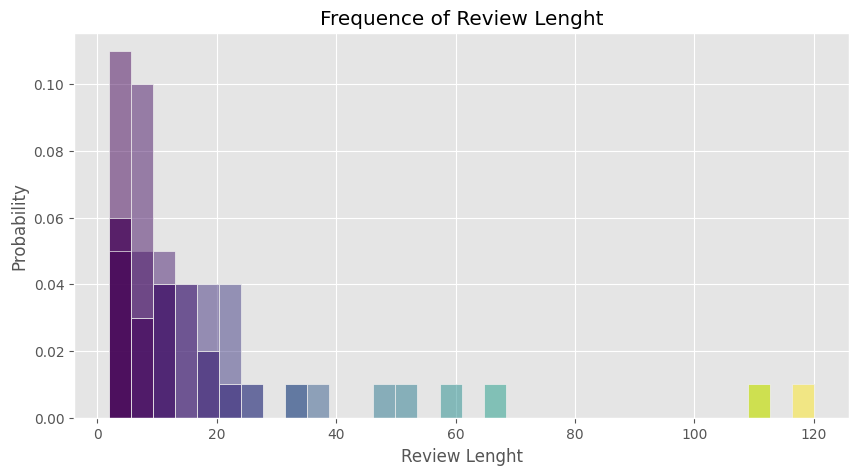

In [61]:
review_lenght = df['Clean Review'].apply(count_words)

plt.figure(figsize=(10, 5))
sns.histplot(x=review_lenght, bins=len(review_lenght.unique()), kde=False, palette='viridis', hue=review_lenght, stat='probability', legend=False)

# Add labels and title
plt.xlabel('Review Lenght')
plt.title('Frequence of Review Lenght')

# Show the plot
plt.show()

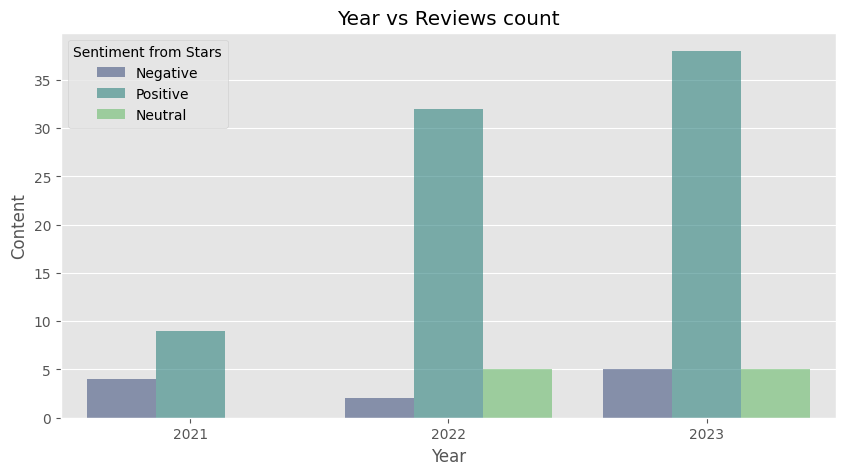

In [62]:
plt.figure(figsize=(10, 5))
Year = pd.DataFrame(df.groupby(['Year', 'Sentiment from Stars'])['Content'].count()).reset_index()

sns.barplot(x="Year", y="Content", hue='Sentiment from Stars', data=Year, palette='viridis', alpha=0.6)

# Add labels and title
plt.title('Year vs Reviews count')
plt.xlabel('Year')

# Show the plot
plt.show()

In [63]:
pos_reviews = " ".join(df[df['Sentiment from Stars'] == 'Positive']['Clean Review'])

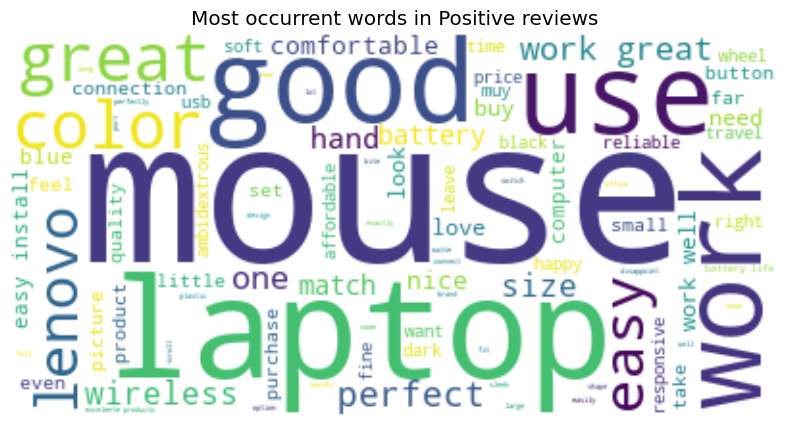

In [64]:
# generate and plot wordcloud for positive reviews
wordcloud = WordCloud(background_color="white", max_words=len(pos_reviews))
wordcloud.generate(pos_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Positive reviews")
plt.show()

In [65]:
neu_reviews = " ".join(df[df['Sentiment from Stars'] == 'Neutral']['Clean Review'])

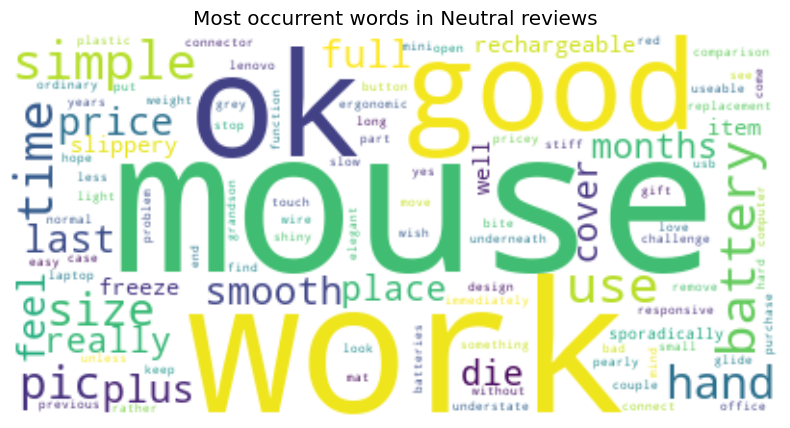

In [66]:
# generate and plot wordcloud for neutral reviews
wordcloud = WordCloud(background_color="white", max_words=len(neu_reviews))
wordcloud.generate(neu_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Neutral reviews")
plt.show()

In [67]:
neg_reviews = " ".join(df[df['Sentiment from Stars'] == 'Negative']['Clean Review'])

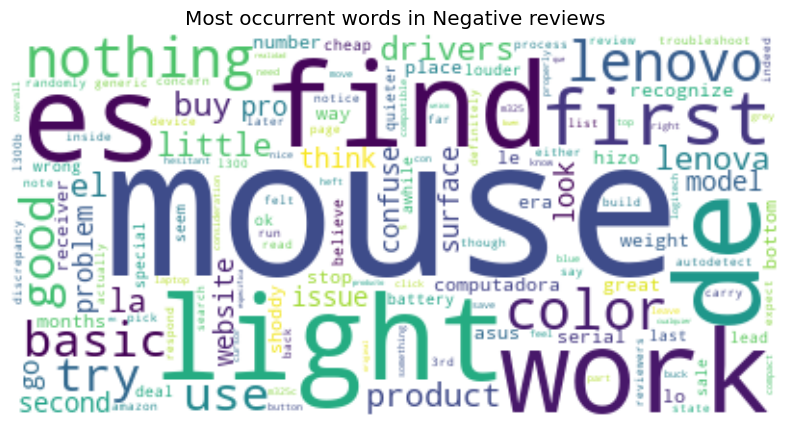

In [68]:
# generate and plot wordcloud for neutral reviews
wordcloud = WordCloud(background_color="white", max_words=len(neg_reviews))
wordcloud.generate(neg_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Negative reviews")
plt.show()

## Data Modelling

Calculate the sentiment only based on the stars the user give to the product can be inconsistent, since for someone 3 stars have a meaning while for someone else they have another meaning. In order to avoid all the process of machine learning to be less precise and based on a fragile calculation I decided to calculate the sentiment using other models.

### VADER

VADER is a pre-built, rule-based sentiment analysis tool that is specifically designed for social media text. It assigns a polarity score to each word and combines them to generate an overall sentiment score.

In [71]:
def sentiment_vader(content):
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(content)
    if score['compound'] >= 0.5:
        sentiment = 'Positive'
    elif score['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment

In [72]:
df['Sentiment from VADER'] = df['Clean Review'].apply(sentiment_vader)

In [79]:
print(df['Sentiment from Stars'].value_counts())
print(df['Sentiment from VADER'].value_counts())

Sentiment from Stars
Positive    79
Negative    11
Neutral     10
Name: count, dtype: int64
Sentiment from VADER
Positive    70
Neutral     24
Negative     6
Name: count, dtype: int64


Since the standard one with all the words could not be admissible since Machine Learning Models doesn't know how to interpret a certain word in order to classify a phrase, I needed to map every review according to the word it has in it.

To do so there is a particular module of sklearn.feature_extraction.text, **TfidfVectorizer** that allows us to create a dense matrix in order to see for every word a level of beloging to every review.

To calculate that level of belonging the module uses a formula:
$$
W_{x,y} = tf_{x,y} * \log{\frac{N}{df_x}}
$$

Where:
1. $ W_{x,y} $ is word x within review y;
2. $tf_{x,y}$ is the frequency of x in y;
3. $df_x$ is the number of review containing x;
4. $N$ is the total number of reviews

In [ ]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Lemmatized Full Review'])
feature_names = vectorizer.get_feature_names_out()
matrix = vectors.todense()
list_dense = matrix.tolist()
sparse_matrix = pd.DataFrame(list_dense, columns=feature_names)

Doing that I can assign to every row of the matrix containing all the reviews the same value of polarity, since the order is still the same 

In [ ]:
sparse_matrix['Polarity_Text'] = list_polarity

In [ ]:
sparse_matrix.sample(10)

### Writing dataframe and sparse matrix into two files

In [ ]:
df.to_csv('data_final.csv', index=False)

In [ ]:
sparse_matrix.to_csv('matrix.csv', index=False)